# US Geodata

In [2]:
import os
import sys

from IPython.display import IFrame
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import numpy as np
import missingno as msno
import seaborn as sns
import matplotlib.patches as patches
import warnings
import networkx as nx
import osmnx as ox
import requests
import matplotlib.cm as cm
import matplotlib.colors as colors

import urllib
import zipfile
import glob

## Downloading US geodata through census.gov

The [US Census Bureau](https://www.census.gov/) has [Cartographic Boundary Files](https://www.census.gov/geographies/mapping-files/time-series/geo/carto-boundary-file.html) available for download.

[![census_geographies_mapping-files](https://raw.githubusercontent.com/katkim0307/COVID-19_Response_Comparison/master/Data/image/census_geo_map_page.PNG)](https://www.census.gov/geographies/mapping-files/time-series/geo/carto-boundary-file.html)


#### Additional Link for another shapefile from [DATA.GOV](https://catalog.data.gov/dataset/tiger-line-shapefile-2017-nation-u-s-current-county-and-equivalent-national-shapefile)

## Download the zipfile and store it in the Data folder

In [44]:
us_counties_url = 'https://www2.census.gov/geo/tiger/GENZ2018/shp/cb_2018_us_county_5m.zip'

In [45]:
urllib.request.urlretrieve(us_counties_url, "Data/input/us_counties.zip")

('Data/input/us_counties.zip', <http.client.HTTPMessage at 0x1d97c7d5848>)

## Unzip the zipfile and Extract

In [46]:
us_counties_zip = zipfile.ZipFile('Data/input/us_counties.zip')

us_counties_zip

<zipfile.ZipFile filename='Data/input/us_counties.zip' mode='r'>

In [47]:
us_counties_zip.extractall('Data/input/us_counties')

## Look in the directory and see what files are available

In [48]:
glob.glob('Data/input/us_counties/*')

['Data/input/us_counties\\cb_2018_us_county_5m.cpg',
 'Data/input/us_counties\\cb_2018_us_county_5m.dbf',
 'Data/input/us_counties\\cb_2018_us_county_5m.prj',
 'Data/input/us_counties\\cb_2018_us_county_5m.shp',
 'Data/input/us_counties\\cb_2018_us_county_5m.shp.ea.iso.xml',
 'Data/input/us_counties\\cb_2018_us_county_5m.shp.iso.xml',
 'Data/input/us_counties\\cb_2018_us_county_5m.shx']

## Read the shapefile in the directory
### States

In [3]:
# Read US States Boundary Shapefile
us_states_gdf = gpd.read_file('Data/input/us_state/cb_2018_us_state_5m.shp')

# Converting the CRS to US National Atlas Equal Area Projection (EPSG: 2163)
us_states_gdf.to_crs(epsg=2163, inplace=True)

In [8]:
us_states_gdf.head()

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry
0,31,01779792,0400000US31,31,NE,Nebraska,00,198956658395,1371829134,"POLYGON ((-339378.208 -418863.338, -338684.030..."
1,53,01779804,0400000US53,53,WA,Washington,00,172112588220,12559278850,"MULTIPOLYGON (((-1634037.628 566970.701, -1633..."
2,35,00897535,0400000US35,35,NM,New Mexico,00,314196306401,728776523,"POLYGON ((-862284.832 -1454476.300, -862055.89..."
3,46,01785534,0400000US46,46,SD,South Dakota,00,196346981786,3382720225,"POLYGON ((-318890.806 7702.207, -318302.166 76..."
4,48,01779801,0400000US48,48,TX,Texas,00,676653171537,19006305260,"POLYGON ((-630703.394 -1429224.113, -630219.81..."


### Plot States Map

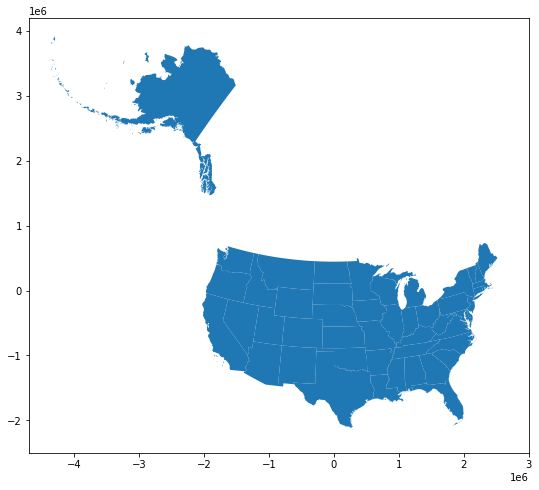

In [7]:
fig, ax = plt.subplots(figsize=(10, 8))

us_states_gdf.plot(
    ax=ax,
);

# Crop the map to an appropriate size (via coordinate)
ax.set_xlim(-4700000, 3000000)
ax.set_ylim(-2500000, 4200000);

### Let's try to label each state with its post code
url: https://stackoverflow.com/questions/38899190/geopandas-label-polygons

In [10]:
us_states_gdf['coords'] = us_states_gdf['geometry'].apply(lambda x: x.representative_point().coords[:])
us_states_gdf['coords'] = [coords[0] for coords in us_states_gdf['coords']]

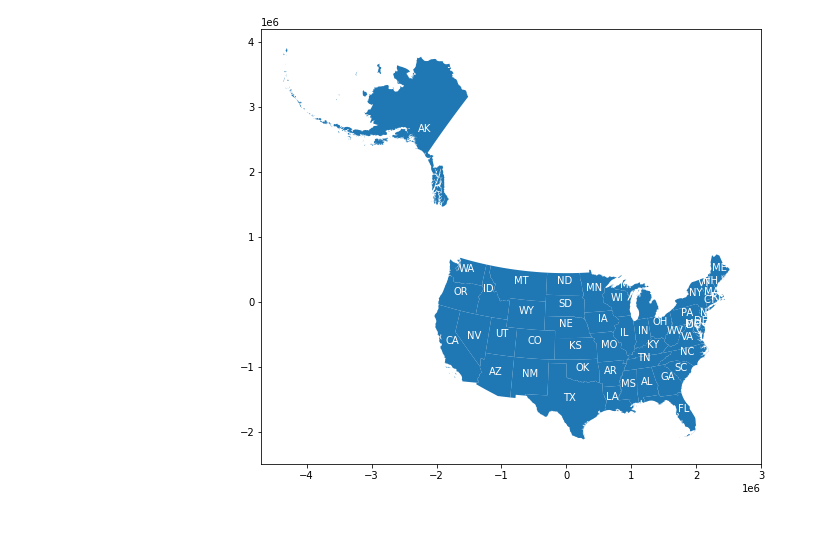

In [30]:
fig, ax = plt.subplots(figsize=(10, 8))

us_states_gdf.plot(
    ax=ax,
);

for idx, row in us_states_gdf.iterrows():
    plt.annotate(s=row['STUSPS'], xy=row['coords'],
                 horizontalalignment='center',
                 color='white',
                 #bbox={'facecolor':'white', 'alpha':0.5, 'pad':1, 'edgecolor':'lightyellow'}
                )

# This didn't work
# ax = us_states_gdf.plot()
# us_states_gdf.apply(lambda x: ax.annotate(s=us_states_gdf.STUSPS, xy=us_states_gdf.geometry.centroid.coords[0], ha='center'),axis=1);
    
    

# Crop the map to an appropriate size (via coordinate)
ax.set_xlim(-4700000, 3000000)
ax.set_ylim(-2500000, 4200000);



### Counties

In [2]:
us_counties_gdf = gpd.read_file('Data/input/us_counties/cb_2018_us_county_5m.shp')

us_counties_gdf.head()

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry
0,39,071,01074048,0500000US39071,39071,Highland,06,1432479992,12194983,"POLYGON ((-83.86976 39.05553, -83.86568 39.247..."
1,06,003,01675840,0500000US06003,06003,Alpine,06,1912292630,12557304,"POLYGON ((-120.07248 38.50987, -120.07239 38.7..."
2,12,033,00295737,0500000US12033,12033,Escambia,06,1701544502,563927612,"POLYGON ((-87.62999 30.87766, -87.62946 30.880..."
3,17,101,00424252,0500000US17101,17101,Lawrence,06,963936864,5077783,"POLYGON ((-87.91028 38.57493, -87.90811 38.850..."
4,28,153,00695797,0500000US28153,28153,Wayne,06,2099745573,7255476,"POLYGON ((-88.94317 31.78421, -88.94335 31.824..."


In [58]:
us_counties_gdf['FULLFP'] = us_counties_gdf['STATEFP']+us_counties_gdf['COUNTYFP']

In [68]:
us_counties_gdf.shape

(3233, 10)

In [69]:
us_counties_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 3233 entries, 0 to 3232
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   STATEFP   3233 non-null   object  
 1   COUNTYFP  3233 non-null   object  
 2   COUNTYNS  3233 non-null   object  
 3   AFFGEOID  3233 non-null   object  
 4   GEOID     3233 non-null   object  
 5   NAME      3233 non-null   object  
 6   LSAD      3233 non-null   object  
 7   ALAND     3233 non-null   int64   
 8   AWATER    3233 non-null   int64   
 9   geometry  3233 non-null   geometry
dtypes: geometry(1), int64(2), object(7)
memory usage: 252.7+ KB


In [70]:
us_counties_gdf.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - NAD83
- bounds: (167.65, 14.92, -47.74, 86.46)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [3]:
us_counties_gdf.to_crs(epsg=2163, inplace=True)

In [72]:
ny_counties_gdf = us_counties_gdf[us_counties_gdf['STATEFP']=='36']

ny_counties_gdf.head()

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry
7,36,001,00974099,0500000US36001,36001,Albany,06,1354120790,27124553,"POLYGON ((2069684.731 43649.020, 2069548.058 4..."
84,36,049,00974123,0500000US36049,36049,Lewis,06,3301307118,39612945,"POLYGON ((1900768.810 162138.225, 1907176.596 ..."
129,36,099,00974147,0500000US36099,36099,Seneca,06,838403627,172828921,"POLYGON ((1845543.525 26340.393, 1846599.750 2..."
160,36,097,00974146,0500000US36097,36097,Schuyler,06,850405404,36246373,"POLYGON ((1847236.646 -18212.765, 1856398.927 ..."
201,36,003,00974100,0500000US36003,36003,Allegany,06,2666029673,12999275,"POLYGON ((1752163.062 -40818.995, 1773075.109 ..."


In [55]:
ny_counties_gdf.shape

(62, 10)

## Problem 1: There is no State Name, only State Fips code

### Let's get the State name by merging `us_counties_gdf` with `Data/input/us_state_fips/us-state-ansi-fips.csv`

In [24]:
fips_csv_dir = 'Data/input/us_state_fips/us-state-ansi-fips.csv'

In [25]:
# make sure the dtype of ' fips' is object not int
fips_df = pd.read_csv(fips_csv_dir, dtype={' fips':object})

fips_df.head()

,stname,fips,stusps
0,Alabama,01,AL
1,Alaska,02,AK
2,Arizona,04,AZ
3,Arkansas,05,AR
4,California,06,CA


In [15]:
fips_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   stname   51 non-null     object
 1    fips    51 non-null     object
 2    stusps  51 non-null     object
dtypes: object(3)
memory usage: 1.3+ KB


In [26]:
fips_df.rename(columns=
    {' fips': 'fips',
    ' stusps': 'postcode',},
    inplace=True)

In [27]:
fips_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   stname    51 non-null     object
 1   fips      51 non-null     object
 2   postcode  51 non-null     object
dtypes: object(3)
memory usage: 1.3+ KB


## Attribute Joins - Merging `us_counties_gdf` and `fips_df` on `'STATEFP'` and `'fips'`



In [33]:
merged_df = pd.merge(
    left=us_counties_gdf, 
    right=fips_df, 
    how='left', 
    left_on='STATEFP', 
    right_on='fips'
)

merged_df.head()

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry,stname,fips,postcode
0,39,071,01074048,0500000US39071,39071,Highland,06,1432479992,12194983,"POLYGON ((1383839.359 -525651.029, 1380276.774...",Ohio,39,OH
1,06,003,01675840,0500000US06003,06003,Alpine,06,1912292630,12557304,"POLYGON ((-1728380.546 -511146.186, -1723528.3...",California,06,CA
2,12,033,00295737,0500000US12033,12033,Escambia,06,1701544502,563927612,"POLYGON ((1184574.215 -1481219.222, 1184591.56...",Florida,12,FL
3,17,101,00424252,0500000US17101,17101,Lawrence,06,963936864,5077783,"POLYGON ((1048064.380 -637787.435, 1044072.379...",Illinois,17,IL
4,28,153,00695797,0500000US28153,28153,Wayne,06,2099745573,7255476,"POLYGON ((1048529.367 -1398672.658, 1048009.79...",Mississippi,28,MS


In [34]:
merged_df = merged_df.drop(['fips'], axis=1)

merged_df.head()

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry,stname,postcode
0,39,071,01074048,0500000US39071,39071,Highland,06,1432479992,12194983,"POLYGON ((1383839.359 -525651.029, 1380276.774...",Ohio,OH
1,06,003,01675840,0500000US06003,06003,Alpine,06,1912292630,12557304,"POLYGON ((-1728380.546 -511146.186, -1723528.3...",California,CA
2,12,033,00295737,0500000US12033,12033,Escambia,06,1701544502,563927612,"POLYGON ((1184574.215 -1481219.222, 1184591.56...",Florida,FL
3,17,101,00424252,0500000US17101,17101,Lawrence,06,963936864,5077783,"POLYGON ((1048064.380 -637787.435, 1044072.379...",Illinois,IL
4,28,153,00695797,0500000US28153,28153,Wayne,06,2099745573,7255476,"POLYGON ((1048529.367 -1398672.658, 1048009.79...",Mississippi,MS


In [36]:
# merged_df[merged_df['stname'].isnull()]

## Now let's convert it back to a GeoDataFrame

In [49]:
us_counties_gdf = gpd.GeoDataFrame(merged_df, geometry=merged_df['geometry'])

us_counties_gdf.head()

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry,stname,postcode
0,39,071,01074048,0500000US39071,39071,Highland,06,1432479992,12194983,"POLYGON ((1383839.359 -525651.029, 1380276.774...",Ohio,OH
1,06,003,01675840,0500000US06003,06003,Alpine,06,1912292630,12557304,"POLYGON ((-1728380.546 -511146.186, -1723528.3...",California,CA
2,12,033,00295737,0500000US12033,12033,Escambia,06,1701544502,563927612,"POLYGON ((1184574.215 -1481219.222, 1184591.56...",Florida,FL
3,17,101,00424252,0500000US17101,17101,Lawrence,06,963936864,5077783,"POLYGON ((1048064.380 -637787.435, 1044072.379...",Illinois,IL
4,28,153,00695797,0500000US28153,28153,Wayne,06,2099745573,7255476,"POLYGON ((1048529.367 -1398672.658, 1048009.79...",Mississippi,MS


In [38]:
us_counties_gdf.shape

(3233, 12)

## Plot the US Counties map

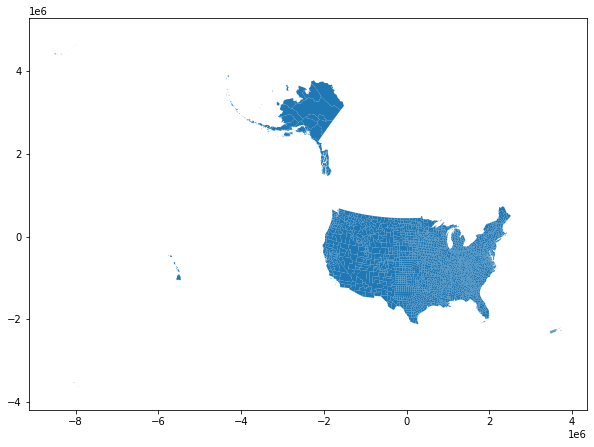

In [50]:
us_counties_gdf.plot(figsize=(10, 10));

## Uh oh..  What's going on?

There are US States/Territories that I don't want to include for data mapping purposes.  They are Palau (PW/70), Guam (GU/66), Northern Mariana Islands (MP/69), American Samoa (AS/60), Hawaii (HI/15), Puerto Rico (PR/72), and Virgin Islnads (VI/78). So let's set the limit for x-axis and y-axis.

In [40]:
# us_counties_gdf = us_counties_gdf[
#     (us_counties_gdf['STATEFP'] != '70') &
#     (us_counties_gdf['STATEFP'] != '66') &
#     (us_counties_gdf['STATEFP'] != '69') &
#     (us_counties_gdf['STATEFP'] != '60') &
#     (us_counties_gdf['STATEFP'] != '15') &
#     (us_counties_gdf['STATEFP'] != '72') &
#     (us_counties_gdf['STATEFP'] != '78')
# ]

In [1]:
fig, ax = plt.subplots(figsize=(15, 15))

us_counties_gdf.plot(
    ax=ax,
    column='STATEFP',
    alpha=0.7,
);

# title
ax.set_title('US States and Counties (epsg: 2163)', fontdict={'size':30})

# turning off scientific notation
#plt.ticklabel_format(useOffset=False)
ax.get_xaxis().get_major_formatter().set_useOffset(False)
ax.get_yaxis().get_major_formatter().set_useOffset(False)

# set the limit for both axes
ax.set_xlim(-4700000, 3000000)
ax.set_ylim(-2500000, 4200000);


NameError: name 'plt' is not defined

# Now let's repeat everything for US States without Counties

In [65]:
us_states_gdf = gpd.read_file('Data/input/us_state/cb_2018_us_state_5m.shp')

us_states_gdf.head()

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry
0,31,01779792,0400000US31,31,NE,Nebraska,00,198956658395,1371829134,"POLYGON ((-104.05351 41.15726, -104.05267 41.2..."
1,53,01779804,0400000US53,53,WA,Washington,00,172112588220,12559278850,"MULTIPOLYGON (((-122.32834 48.02134, -122.3217..."
2,35,00897535,0400000US35,35,NM,New Mexico,00,314196306401,728776523,"POLYGON ((-109.05017 31.48000, -109.04984 31.4..."
3,46,01785534,0400000US46,46,SD,South Dakota,00,196346981786,3382720225,"POLYGON ((-104.05770 44.99743, -104.05021 44.9..."
4,48,01779801,0400000US48,48,TX,Texas,00,676653171537,19006305260,"POLYGON ((-106.64548 31.89867, -106.64084 31.9..."


In [67]:
us_states_gdf.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - NAD83
- bounds: (167.65, 14.92, -47.74, 86.46)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich